# Vertex AI MLOPs 

## (Data Collection >> Model Training >> Model Evaluation >> Model Deployment >> Model Monitoring)




### Vialink Demo Presentation

- Jyothish CHANDRASENAN

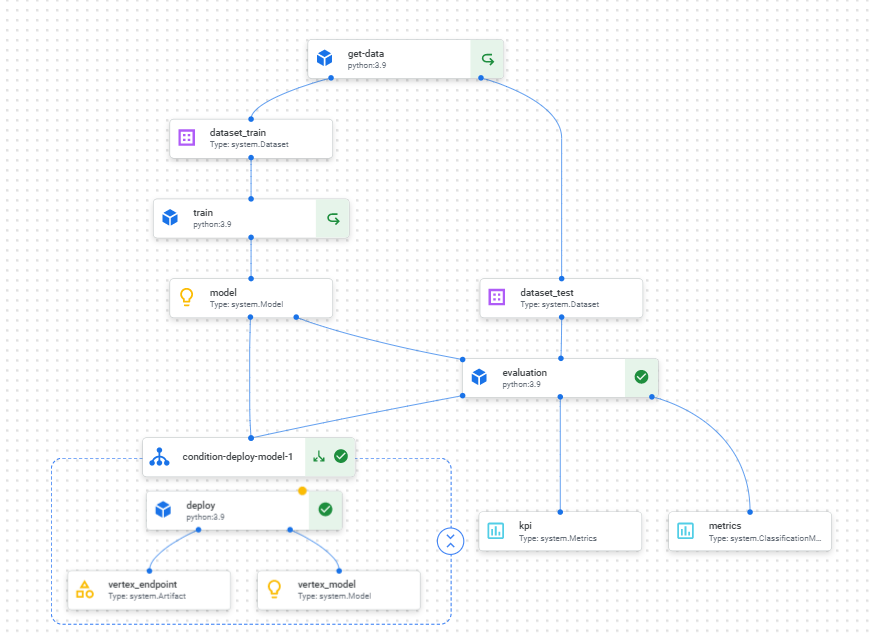

## Installation of libraries 

- google-cloud-aiplatform : https://github.com/googleapis/python-aiplatform
- kubeflowpipelines : https://github.com/kubeflow/pipelines

In [1]:
USER_FLAG = "--user"
# Install ai platform and kfp
!pip3 install {USER_FLAG} google-cloud-aiplatform --upgrade
!pip3 install {USER_FLAG} kfp --upgrade

# Enable necessary APIS

In [2]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

Operation "operations/acat.p2-363382951674-0fa111b5-6e9d-4a17-9d29-96d1a1b44573" finished successfully.


# Import the modules

In [3]:
from typing import NamedTuple
from kfp.v2 import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import component, pipeline
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        OutputPath, 
                        InputPath)

from google.cloud import aiplatform

# Project Configuration

In [4]:
PROJECT_ID = "tribal-dispatch-383516"
REGION="europe-west1"
BUCKET_NAME="gs://demo-vialink"
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_test/"
EXPERIMENT_NAME = "mvp-vertex-pipeline"
PIPELINE_NAME = 'ml-pipeline-test'


# Wine Quality Classification 

The idea is to predict the quality of the wine based on the following criteria:

- volatile acidity: volatile acidity is the gaseous acid present in wine.
- fixed acidity: primarily fixed acids found in wine are tartaric, succinic, citric, and malic
- residual sugar: the amount of sugar left after fermentation.
- citric acid: it is a weak organic acid, found in citrus fruits naturally.
- chlorides: the amount of salt present in wine.
- free sulfur dioxide: So2 is used for the prevention of wine by oxidation and microbial spoilage.
- pH: in wine pH is used for checking acidity
- density
- sulfates: added sulfites preserve freshness and protect wine from oxidation, and bacteria.
- alcohol: percent of alcohol present in wine.
 
### The target to be predicted is based on the quality grade of the wine:

- good wine = 1 (quality grade ≥7 )
- bad wine = 0 (quality grade < 7 )

# Explore the Dataset

In [5]:
# List columns
import pandas as pd

pd.set_option('display.max_columns', None)
df_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# Component 1

- Purpose - Get the data ready
- Outputs - train dataset and test dataset

In [6]:
@component(
    packages_to_install=["pandas", "pyarrow",  "scikit-learn"],
    base_image="python:3.9",
    output_component_file="get_data.yaml"
)

def get_data(
    url: str,
    dataset_train: Output[Dataset],
    dataset_test: Output[Dataset]
):
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    df_wine = pd.read_csv(url, delimiter=";")
    df_wine['best_quality'] = [ 1 if x>=7 else 0 for x in df_wine.quality] 
    df_wine['target'] = df_wine.best_quality
    df_wine = df_wine.drop(['quality', 'total sulfur dioxide', 'best_quality'], axis=1)
   
   
    train, test = train_test_split(df_wine, test_size=0.3)
    train.to_csv(dataset_train.path + ".csv" , index=False, encoding='utf-8-sig')
    test.to_csv(dataset_test.path + ".csv" , index=False, encoding='utf-8-sig')

# Component 2

- Purpose: Train a Machine Learning Model
- Input : Train Dataset
- Output : Model weights

In [7]:
@component(
    packages_to_install = ["pandas","scikit-learn",],
    base_image="python:3.9",
    output_component_file="train.yaml"
)
def train(
    dataset:  Input[Dataset],
    model: Output[Model], 
):
    
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import pickle

    data = pd.read_csv(dataset.path+".csv")
    model_rf = RandomForestClassifier(n_estimators=10)
    model_rf.fit(data.drop(columns=["target"]),data.target,)
    model.metadata["framework"] = "scikit-learn"
    model.metadata["alogirthm"] = "Random Forest"
    file_name = model.path + f".pkl"
    with open(file_name, 'wb') as file:  
        pickle.dump(model_rf, file)

# Component 3

- Purpose: Evaluate the trained Machine Learning Model
- Input : Test Dataset, Trained model weights
- Output : Metrics

In [8]:
@component(
    packages_to_install = ["pandas","scikit-learn"],
    base_image="python:3.9",
    output_component_file="evaluation.yaml"
)
def evaluation(
    test_set:  Input[Dataset],
    rf_winequality_model: Input[Model],
    thresholds_dict_str: str,
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics]
) -> NamedTuple("output", [("deploy", str)]):

    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import logging 
    import pickle
    from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score
    import json
    import typing

    
    def threshold_check(val1, val2):
        cond = "false"
        if val1 >= val2 :
            cond = "true"
        return cond

    data = pd.read_csv(test_set.path+".csv")
    model = RandomForestClassifier()
    file_name = rf_winequality_model.path + ".pkl"
    with open(file_name, 'rb') as file:  
        model = pickle.load(file)
    
    y_test = data.drop(columns=["target"])
    y_target=data.target
    y_pred = model.predict(y_test)
    

    y_scores =  model.predict_proba(y_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(
         y_true=data.target.to_numpy(), y_score=y_scores, pos_label=True
    )
    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())  
    
    metrics.log_confusion_matrix(
       ["False", "True"],
       confusion_matrix(
           data.target, y_pred
       ).tolist(), 
    )
    
    accuracy = accuracy_score(data.target, y_pred.round())
    thresholds_dict = json.loads(thresholds_dict_str)
    rf_winequality_model.metadata["accuracy"] = float(accuracy)
    kpi.log_metric("accuracy", float(accuracy))
    deploy = threshold_check(float(accuracy), int(thresholds_dict['accuracy']))
    
    return (deploy,)

# Component 4

- Purpose : Deployment of Machine Learning Model
- Input : Trained Model
- Output : Serving Endpoint

In [9]:
@component(
    packages_to_install=["google-cloud-aiplatform", "scikit-learn==1.0.0",  "kfp"],
    base_image="python:3.9",
    output_component_file="deploy.yaml"
)
def deploy(
    model: Input[Model],
    project: str,
    region: str,
    serving_container_image_uri : str, 
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
): 
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)

    DISPLAY_NAME  = "vertex-ai-deployment-test"
    MODEL_NAME = "model-test"
    ENDPOINT_NAME = "endpoint-test"
    
    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=project, 
        location=region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=project, location=region
        )
    
    endpoint = create_endpoint()   
    
    
    #Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = DISPLAY_NAME, 
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri =  serving_container_image_uri,
        serving_container_health_route=f"/v1/models/{MODEL_NAME}",
        serving_container_predict_route=f"/v1/models/{MODEL_NAME}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": MODEL_NAME,
    },       
    )
    model_deploy = model_upload.deploy(
        min_replica_count=1,
        max_replica_count=5,
        machine_type="n1-standard-4", 
        # accelerator_type='NVIDIA_TESLA_K80',
        # accelerator_count=1,
        endpoint=endpoint,
        # traffic_split={"0": 100},
        traffic_percentage=100,
        deploy_request_timeout=1200,
        deployed_model_display_name=DISPLAY_NAME,
    )
    
    # Save data to the output params
    vertex_model.uri = model_deploy.resource_name

# Create a Pipeline in Vertex AI

In [10]:
from datetime import datetime
TIMESTAMP =datetime.now().strftime("%Y%m%d%H%M%S")
DISPLAY_NAME = 'demo-pipeline-{}'.format(TIMESTAMP)

In [11]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name=PIPELINE_NAME,
    
)
def pipeline(
    url: str = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
    project: str = PROJECT_ID,
    region: str = REGION, 
    display_name: str = DISPLAY_NAME,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"accuracy":0.8}', 
    serving_container_image_uri: str = "europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    ):
    
    data_op = get_data(url)
    train_model_op = train(data_op.outputs["dataset_train"])
    model_evaluation_op = evaluation(
        test_set=data_op.outputs["dataset_test"],
        rf_winequality_model=train_model_op.outputs["model"],
        thresholds_dict_str = thresholds_dict_str, # I deploy the model anly if the model performance is above the threshold
    )
    
    with dsl.Condition(
        model_evaluation_op.outputs["deploy"]=="true",
        name="deploy-model",
    ):
           
        deploy_model_op = deploy(
        model=train_model_op.outputs['model'],
        project=project,
        region=region, 
        serving_container_image_uri = serving_container_image_uri,
        )

In [12]:
compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='pipeline.json')

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1293: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [13]:
job = aiplatform.PipelineJob(
    display_name="{PIPELINE_NAME}",
    template_path="pipeline.json",
    enable_caching=True,
    location=REGION,
)

In [14]:
job.submit(experiment=EXPERIMENT_NAME)  

Creating PipelineJob
PipelineJob created. Resource name: projects/363382951674/locations/europe-west1/pipelineJobs/ml-pipeline-test-20230416075359
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/363382951674/locations/europe-west1/pipelineJobs/ml-pipeline-test-20230416075359')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/ml-pipeline-test-20230416075359?project=363382951674
Associating projects/363382951674/locations/europe-west1/pipelineJobs/ml-pipeline-test-20230416075359 to Experiment: mvp-vertex-pipeline


In [15]:
response = job.name
response

'ml-pipeline-test-20230416075359'

In [16]:
# job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/363382951674/locations/europe-west1/pipelineJobs/pipeline-winequality-20230415084319
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/363382951674/locations/europe-west1/pipelineJobs/pipeline-winequality-20230415084319')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/pipeline-winequality-20230415084319?project=363382951674
PipelineJob projects/363382951674/locations/europe-west1/pipelineJobs/pipeline-winequality-20230415084319 current state:
PipelineState.PIPELINE_STATE_PENDING
PipelineJob projects/363382951674/locations/europe-west1/pipelineJobs/pipeline-winequality-20230415084319 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/363382951674/locations/europe-west1/pipelineJobs/pipeline-winequality-20230415084319 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/363382951674/l

# Test a sample request in the deployed endpoint

In [17]:
ENDPOINT_NAME="vertex-ai-deployment-test_endpoint"
ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)'\
              --filter=display_name=$ENDPOINT_NAME \
              --sort-by=creationTimeStamp | tail -1)
print(ENDPOINT_ID)
ENDPOINT_ID = ENDPOINT_ID[1]
ENDPOINT_ID

['Using endpoint [https://europe-west1-aiplatform.googleapis.com/]', '2690883185167826944']


'2690883185167826944'

In [18]:
def endpoint_predict(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    
    return prediction

In [27]:
instance = [[4,2,5,7,7,25,35,6,8,1]]

In [28]:
prediction_request = endpoint_predict(PROJECT_ID, REGION, instance, ENDPOINT_ID)
print(prediction_request)

Prediction(predictions=[0.0], deployed_model_id='5869958329161220096', model_version_id='1', model_resource_name='projects/363382951674/locations/europe-west1/models/7768929259539660800', explanations=None)


In [29]:
target_prediction = prediction_request[0]
target_prediction

[0.0]

# Create Cloud Scheduler and Cloud Function

- Purpose : to schedule the pipeline triggering

In [26]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
                project_id=PROJECT_ID,
                region=REGION,
                )

# SERVICE_ACCOUNT = (
#     "XXXXXX@developer.gserviceaccount.com" 
# )
response = api_client.create_schedule_from_job_spec(
    enable_caching=True,
    job_spec_path="pipeline.json",
    schedule="0 0 * * 1", #//once per week on Monday
    time_zone="Europe/Brussels",  # change this as necessary
    parameter_values={"display_name": DISPLAY_NAME},
    pipeline_root=PIPELINE_ROOT,  
    # service_account=SERVICE_ACCOUNT,    
)
response

{'name': 'projects/tribal-dispatch-383516/locations/europe-west1/jobs/pipeline_ml-pipeline-test_34d1e837_0-0-a-a-1',
 'httpTarget': {'uri': 'https://europe-west1-tribal-dispatch-383516.cloudfunctions.net/templated_http_request-v1',
  'httpMethod': 'POST',
  'headers': {'User-Agent': 'Google-Cloud-Scheduler',
   'Content-Type': 'application/octet-stream'},
  'body': 'eyJwaXBlbGluZVNwZWMiOiB7ImNvbXBvbmVudHMiOiB7ImNvbXAtY29uZGl0aW9uLWRlcGxveS1tb2RlbC0xIjogeyJkYWciOiB7InRhc2tzIjogeyJkZXBsb3kiOiB7ImNhY2hpbmdPcHRpb25zIjogeyJlbmFibGVDYWNoZSI6IHRydWV9LCAiY29tcG9uZW50UmVmIjogeyJuYW1lIjogImNvbXAtZGVwbG95In0sICJpbnB1dHMiOiB7ImFydGlmYWN0cyI6IHsibW9kZWwiOiB7ImNvbXBvbmVudElucHV0QXJ0aWZhY3QiOiAicGlwZWxpbmVwYXJhbS0tdHJhaW4tbW9kZWwifX0sICJwYXJhbWV0ZXJzIjogeyJwcm9qZWN0IjogeyJjb21wb25lbnRJbnB1dFBhcmFtZXRlciI6ICJwaXBlbGluZXBhcmFtLS1wcm9qZWN0In0sICJyZWdpb24iOiB7ImNvbXBvbmVudElucHV0UGFyYW1ldGVyIjogInBpcGVsaW5lcGFyYW0tLXJlZ2lvbiJ9LCAic2VydmluZ19jb250YWluZXJfaW1hZ2VfdXJpIjogeyJjb21wb25lbnRJbnB1dFBhcmFtZXRlciI